In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Set
from datetime import datetime as dt
from functools import partial, wraps

from plasticc.featurize import process_meta, featurize
from plasticc.training import path_from_cv_score, train_and_validate, random_search
from plasticc.final import featurize_test, predict_test

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
fcp = {
    'flux': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        'mean_change': None,
        'mean_abs_change': None,
        'length': None,
    },

    'flux_by_flux_ratio_sq': {
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,       
    },

    'flux_passband': {
        'fft_coefficient': [
                {'coeff': 0, 'attr': 'abs'}, 
                {'coeff': 1, 'attr': 'abs'}
            ],
        'kurtosis' : None,
        'skewness' : None,
        # new:
        'sample_entropy': None,
        'mean_second_derivative_central': None,
        'mean_abs_change': None,
        'index_mass_quantile': [
            {'q': 0.5}
        ],
        'fft_aggregated': [
            {'aggtype': 'centroid'},
            {'aggtype': 'variance'},
            {'aggtype': 'skew'},
            {'aggtype': 'kurtosis'},
        ]
    },

    'mjd': {
        'maximum': None, 
        'minimum': None,
        'mean_change': None,
        'mean_abs_change': None,
    },
}

In [4]:
aggs = {
    'flux': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'flux_err': ['min', 'max', 'mean', 'median', 'std', 'skew'],
    'detected': ['mean'],
    'flux_ratio_sq':['sum', 'skew'],
    'flux_by_flux_ratio_sq':['sum','skew'],
}

### Generate features for model training

In [5]:
%%time
meta_train = process_meta('../data/raw/training_set_metadata.csv')
train = pd.read_csv('../data/raw/training_set.csv')

CPU times: user 2.46 s, sys: 532 ms, total: 2.99 s
Wall time: 1.67 s


In [6]:
%%time
X = featurize(train, meta_train, aggs, fcp, n_jobs=12)

Feature Extraction: 100%|██████████| 60/60 [00:00<00:00, 62.97it/s]


CPU times: user 1min 18s, sys: 2.92 s, total: 1min 21s
Wall time: 37.6 s


In [7]:
if 'target' in X:
    y = X['target']
    del X['target']
else:
    print("What the duck")
    3//0

In [8]:
%%time
train_mean = X.mean(axis=0)
#train_mean.to_hdf('train_data.hdf5', 'data')
# pd.set_option('display.max_rows', 500)
#import pdb; pdb.set_trace()
X.fillna(0, inplace=True)

CPU times: user 272 ms, sys: 0 ns, total: 272 ms
Wall time: 14.3 ms


### Train model with CV

In [9]:
lgbm_params = {
    'device': 'cpu',
    'objective': 'multiclass',
    'num_class': 14,
    'boosting_type': 'gbdt',
    'n_jobs': 16,
    'max_depth': 6,
    'n_estimators': 1024,
    'subsample_freq': 2,
    'subsample_for_bin': 5000,
    'min_data_per_group': 100,
    'max_cat_to_onehot': 4,
    'cat_l2': 1.0,
    'cat_smooth': 59.5,
    'max_cat_threshold': 32,
    'metric_freq': 10,
    'verbosity': -1,
    'metric': 'multi_logloss',
    'xgboost_dart_mode': False,
    'uniform_drop': False,
    'colsample_bytree': 0.33,
    'drop_rate': 0.173,
    'learning_rate': 0.0267,
    'max_drop': 5,
    'min_child_samples': 10,
    'min_child_weight': 100.0,
    'min_split_gain': 0.126,
    'num_leaves': 7,
    'reg_alpha': 0.1,
    'reg_lambda': 0.00023,
    'skip_drop': 0.44,
    'subsample': 0.75,
    'max_bin': 32,
    'min_data_in_leaf': 13,
    'lambda_l1': 2,
}

In [10]:
colnames_to_ignore = set([
    'object_id',
    'hostgal_specz',
    'ra',
    'decl',
    'gal_l',
    'gal_b',
    'ddf',
    
])
colnames_to_ignore_restrictive = colnames_to_ignore | set([
    'latlon1',
    'haversine',
])
colnames_to_ignore_very_restrictive = colnames_to_ignore_restrictive | set([
    'flux_err_skew',
    'flux_by_flux_ratio_sq_sum'
])
id_colname = 'object_id'

In [11]:
feature_colnames = [col for col in X.columns if col not in colnames_to_ignore_very_restrictive]
clfs, score, importances = train_and_validate(
    X=X, 
    y=y,
    feature_colnames=feature_colnames, 
    id_colname=id_colname, 
    model='lgbm', 
    model_params=lgbm_params, 
    nr_fold=4, 
    random_state=1
)
submission_file_path = path_from_cv_score(score, suffix='')
print(submission_file_path)

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.782095	training's wloss: 0.773807	valid_1's multi_logloss: 1.13285	valid_1's wloss: 0.958323
[200]	training's multi_logloss: 0.512056	training's wloss: 0.501005	valid_1's multi_logloss: 0.899936	valid_1's wloss: 0.735906
[300]	training's multi_logloss: 0.401353	training's wloss: 0.389832	valid_1's multi_logloss: 0.811339	valid_1's wloss: 0.668802
[400]	training's multi_logloss: 0.337347	training's wloss: 0.325368	valid_1's multi_logloss: 0.765355	valid_1's wloss: 0.647173
[500]	training's multi_logloss: 0.292275	training's wloss: 0.280822	valid_1's multi_logloss: 0.735506	valid_1's wloss: 0.64204
[600]	training's multi_logloss: 0.257022	training's wloss: 0.245996	valid_1's multi_logloss: 0.711614	valid_1's wloss: 0.638987
Early stopping, best iteration is:
[642]	training's multi_logloss: 0.244318	training's wloss: 0.233468	valid_1's multi_logloss: 0.702548	valid_1's wloss: 0.638086
no 1-fold

In [12]:
desc_importances = importances.sort_values(by='mean_gain', ascending=False)

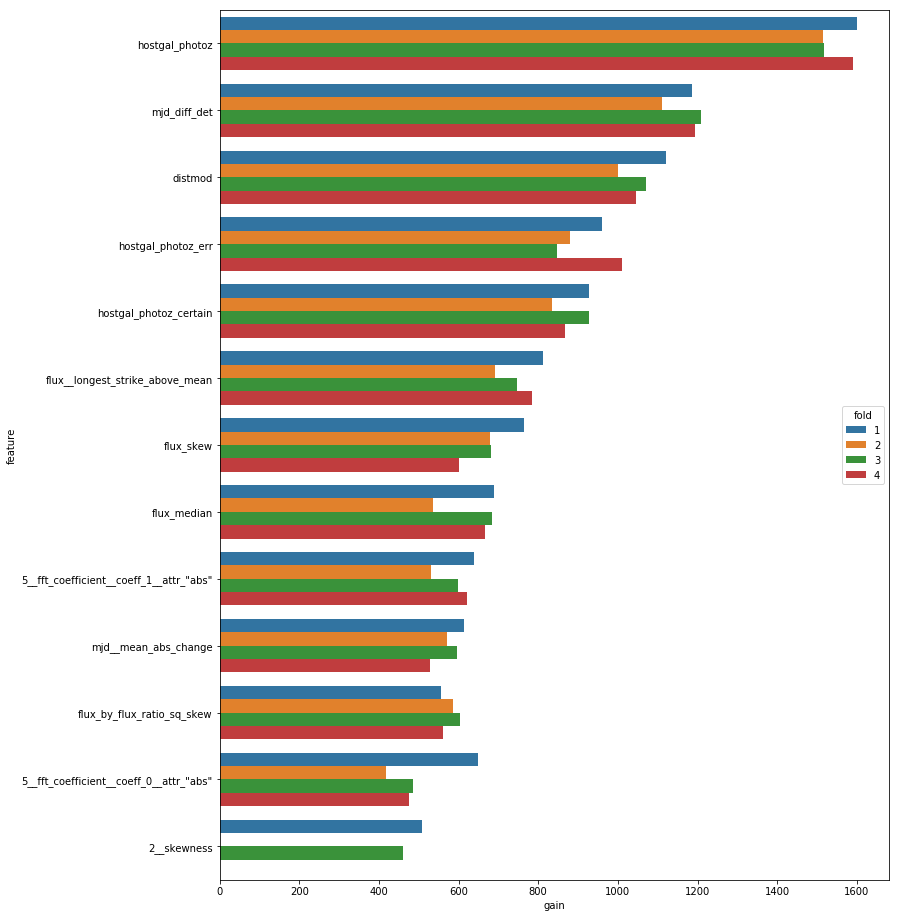

In [13]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=desc_importances.head(50), x='gain', y='feature', hue='fold', )
plt.show()

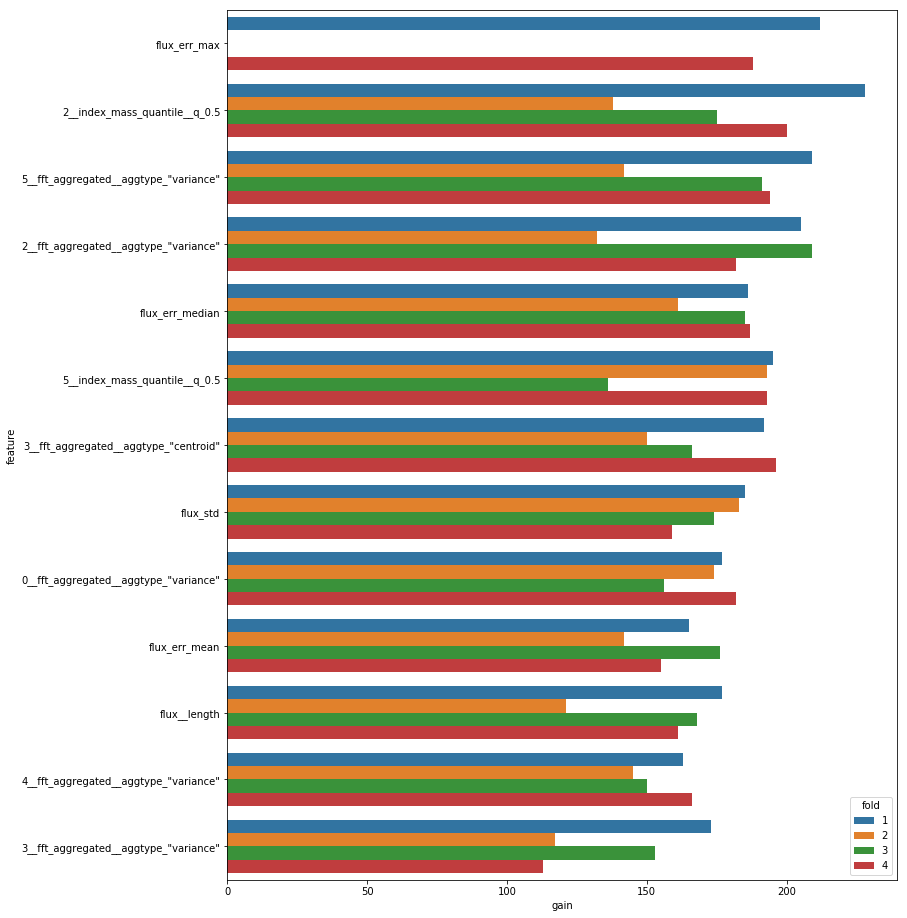

In [14]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=desc_importances.tail(50), x='gain', y='feature', hue='fold')
plt.show()

#### Seems like the model's parameters can be improved a little more by performing a randomized search

In [15]:
lgbm_params

{'device': 'cpu',
 'objective': 'multiclass',
 'num_class': 14,
 'boosting_type': 'gbdt',
 'n_jobs': 16,
 'max_depth': 6,
 'n_estimators': 1024,
 'subsample_freq': 2,
 'subsample_for_bin': 5000,
 'min_data_per_group': 100,
 'max_cat_to_onehot': 4,
 'cat_l2': 1.0,
 'cat_smooth': 59.5,
 'max_cat_threshold': 32,
 'metric_freq': 10,
 'verbosity': -1,
 'metric': 'multi_logloss',
 'xgboost_dart_mode': False,
 'uniform_drop': False,
 'colsample_bytree': 0.33,
 'drop_rate': 0.173,
 'learning_rate': 0.0267,
 'max_drop': 5,
 'min_child_samples': 10,
 'min_child_weight': 100.0,
 'min_split_gain': 0.126,
 'num_leaves': 7,
 'reg_alpha': 0.1,
 'reg_lambda': 0.00023,
 'skip_drop': 0.44,
 'subsample': 0.75,
 'max_bin': 32,
 'min_data_in_leaf': 13,
 'lambda_l1': 2}

In [16]:
tuned_params = {
    'max_depth': [4,6,8,10],
    'n_estimators': [512,1024,2048],
    'max_bin': [4, 8, 16, 32, 64],
    'num_leaves': [3,5,7,9,11,13,15],
    'feature_fraction': [0.25, 0.5, 0.67, 0.75, 0.825, 0.95],
    'verbosity': [0]  # prevent too much output
}

In [17]:
for key in tuned_params:
    print(f"{key}: mean={np.mean(tuned_params[key]):.4f}, std={np.std(tuned_params[key]):.4f}")

max_depth: mean=7.0000, std=2.2361
n_estimators: mean=1194.6667, std=638.5762
max_bin: mean=24.8000, std=21.8211
num_leaves: mean=9.0000, std=4.0000
feature_fraction: mean=0.6575, std=0.2285
verbosity: mean=0.0000, std=0.0000


In [18]:
experiment_params = lgbm_params.copy()
for key in experiment_params.keys():
    experiment_params[key] = [experiment_params[key]]  # 1-element list
experiment_params.update(tuned_params)

In [19]:
experiment_params

{'device': ['cpu'],
 'objective': ['multiclass'],
 'num_class': [14],
 'boosting_type': ['gbdt'],
 'n_jobs': [16],
 'max_depth': [4, 6, 8, 10],
 'n_estimators': [512, 1024, 2048],
 'subsample_freq': [2],
 'subsample_for_bin': [5000],
 'min_data_per_group': [100],
 'max_cat_to_onehot': [4],
 'cat_l2': [1.0],
 'cat_smooth': [59.5],
 'max_cat_threshold': [32],
 'metric_freq': [10],
 'verbosity': [0],
 'metric': ['multi_logloss'],
 'xgboost_dart_mode': [False],
 'uniform_drop': [False],
 'colsample_bytree': [0.33],
 'drop_rate': [0.173],
 'learning_rate': [0.0267],
 'max_drop': [5],
 'min_child_samples': [10],
 'min_child_weight': [100.0],
 'min_split_gain': [0.126],
 'num_leaves': [3, 5, 7, 9, 11, 13, 15],
 'reg_alpha': [0.1],
 'reg_lambda': [0.00023],
 'skip_drop': [0.44],
 'subsample': [0.75],
 'max_bin': [4, 8, 16, 32, 64],
 'min_data_in_leaf': [13],
 'lambda_l1': [2],
 'feature_fraction': [0.25, 0.5, 0.67, 0.75, 0.825, 0.95]}

In [20]:
lens = [len(val) for val in experiment_params.values()]

In [21]:
max_experiments = 1
for l in lens:
    max_experiments*=l
max_experiments  # max number of experiments with specified parameters

2520

In [22]:
%%capture --no-stderr
search_result = random_search(
    n_iter=32,  # TODO: Conduct larger search later
    X=X, 
    y=y,
    feature_colnames=feature_colnames, 
    id_colname=id_colname, 
    model='lgbm', 
    search_params=experiment_params, 
    nr_fold=4, 
    random_state=1
)

100%|██████████| 32/32 [18:57<00:00, 34.05s/it]


In [24]:
best_result = search_result.training_results[search_result.best_idx]

In [25]:
best_result.score

0.6451009144271047

In [43]:
search_result.training_results[0].clfs

[LGBMClassifier(boosting_type='gbdt', cat_l2=1.0, cat_smooth=59.5,
         class_weight=None, colsample_bytree=0.33, device='cpu',
         drop_rate=0.173, feature_fraction=0.95, importance_type='split',
         lambda_l1=2, learning_rate=0.0267, max_bin=32,
         max_cat_threshold=32, max_cat_to_onehot=4, max_depth=10,
         max_drop=5, metric='multi_logloss', metric_freq=10,
         min_child_samples=10, min_child_weight=100.0, min_data_in_leaf=13,
         min_data_per_group=100, min_split_gain=0.126, n_estimators=2048,
         n_jobs=16, num_class=14, num_leaves=3, objective='multiclass',
         random_state=None, reg_alpha=0.1, reg_lambda=0.00023, silent=True,
         skip_drop=0.44, subsample=0.75, subsample_for_bin=5000,
         subsample_freq=2, uniform_drop=False, verbosity=0,
         xgboost_dart_mode=False),
 LGBMClassifier(boosting_type='gbdt', cat_l2=1.0, cat_smooth=59.5,
         class_weight=None, colsample_bytree=0.33, device='cpu',
         drop_rate=0.

In [46]:
sr_series = pd.Series([sr.score for sr in search_result.training_results])

In [49]:
sr_series.sort_values(ascending=True).head(10)

11    0.645101
17    0.648279
7     0.648335
29    0.648734
9     0.652690
0     0.652701
3     0.652709
22    0.653431
31    0.653963
18    0.655342
dtype: float64

In [50]:
indices_to_bag = sr_series.sort_values(ascending=True).head(4)

In [26]:
best_importances = best_result.importances.sort_values(by='mean_gain', ascending=False)

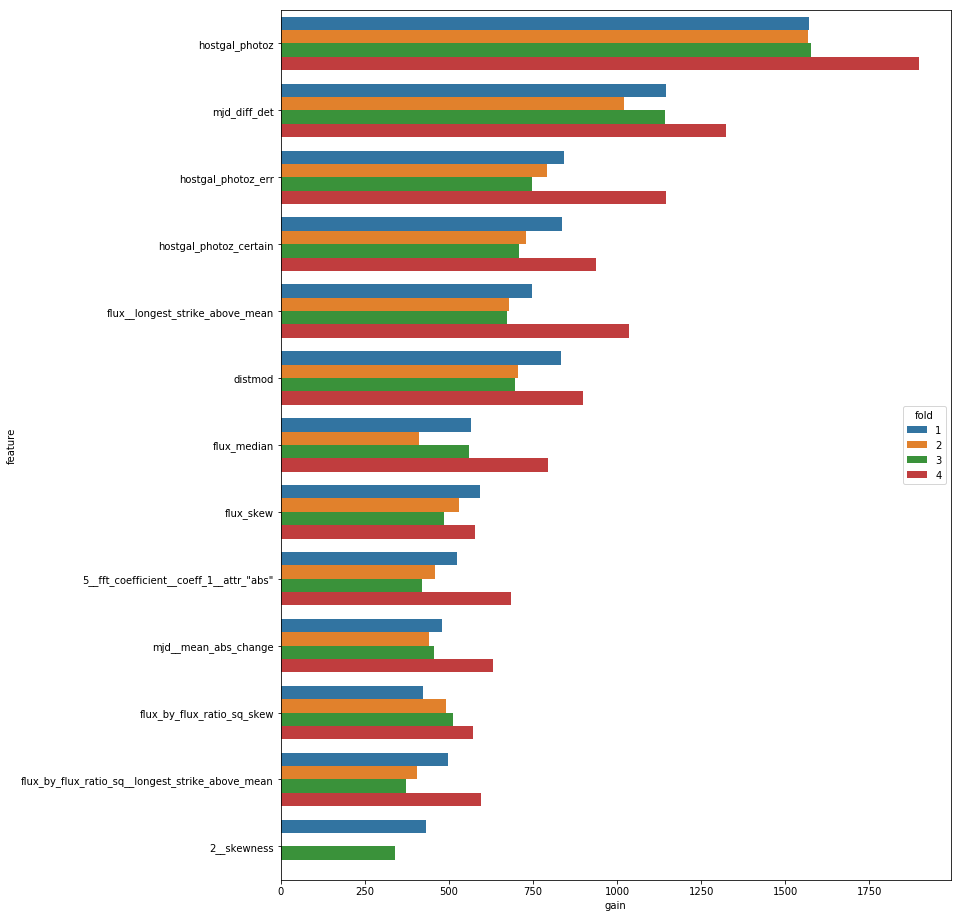

In [27]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=best_importances.head(50), x='gain', y='feature', hue='fold', )
plt.show()

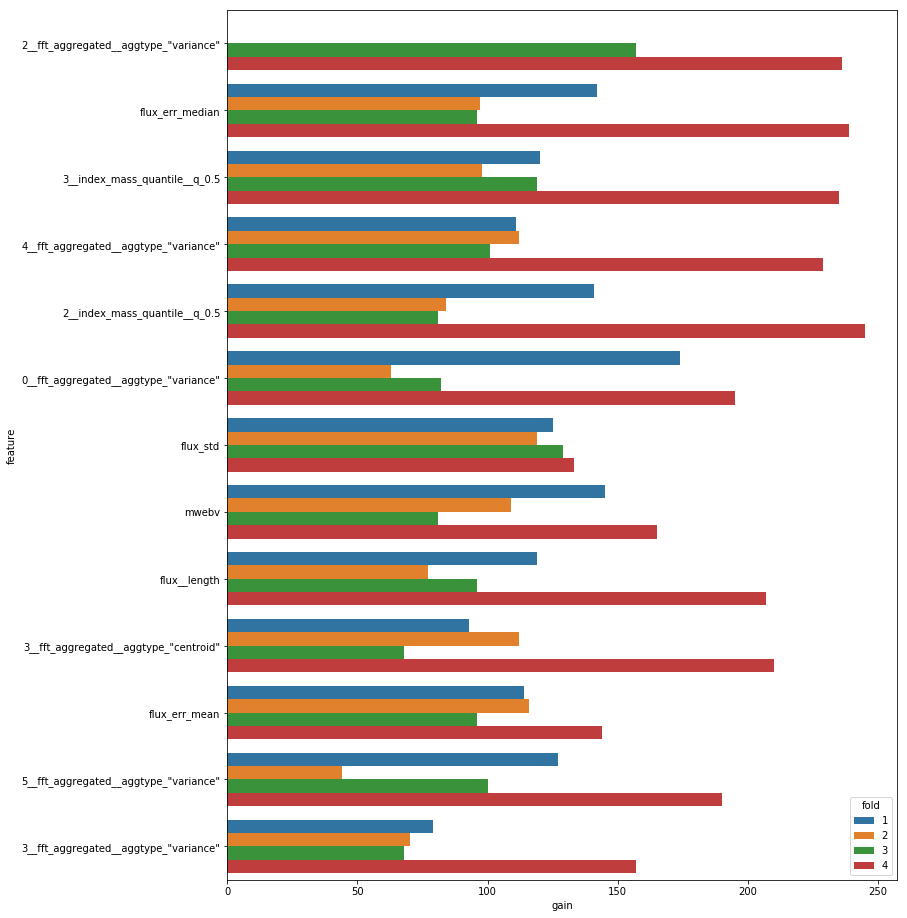

In [28]:
fig, ax = plt.subplots(figsize=(12,16))
sns.barplot(ax=ax, data=best_importances.tail(50), x='gain', y='feature', hue='fold', )
plt.show()

In [32]:
{key: search_result.model_params[search_result.best_idx][key] for key in tuned_params.keys()}

{'max_depth': 8,
 'n_estimators': 1024,
 'max_bin': 16,
 'num_leaves': 5,
 'feature_fraction': 0.5,
 'verbosity': 0}

### Test set features

In [33]:
chunk_size_one_100 = 453653105 // 100 + 1
# chunk_size_one_100 = 1000001 // 100 + 1
chunk_size_one_100

4536532

In [ ]:
%%time
# should take 100x (time after 1st iteration)
featurize_test(
    featurize_configs={'aggs': aggs, 'fcp': fcp}, 
    n_jobs=16,
    meta_path='../data/raw/test_set_metadata.csv',
    test_path='../data/raw/test_set.csv',
    output_path='../data/features/test-more-tsfresh.csv',
    id_colname='object_id',
    chunks=chunk_size_one_100,  # alternatively: 5000000
)

Feature Extraction: 100%|██████████| 80/80 [00:01<00:00, 46.43it/s]


        4536532 done in   1.8 minutes


Feature Extraction: 100%|██████████| 80/80 [00:01<00:00, 40.06it/s]


        9073064 done in   3.6 minutes


Feature Extraction: 100%|██████████| 80/80 [00:03<00:00, 24.27it/s]


       13609596 done in   6.0 minutes


Feature Extraction: 100%|██████████| 80/80 [00:05<00:00, 15.35it/s]


       18146128 done in   8.9 minutes


Feature Extraction: 100%|██████████| 80/80 [00:04<00:00, 19.44it/s]


       22682660 done in  12.5 minutes


Feature Extraction: 100%|██████████| 80/80 [00:04<00:00, 17.28it/s]


       27219192 done in  14.7 minutes


Feature Extraction: 100%|██████████| 80/80 [00:04<00:00, 18.00it/s]


       31755724 done in  16.9 minutes


Feature Extraction: 100%|██████████| 80/80 [00:03<00:00, 28.00it/s]


       36292256 done in  19.2 minutes


Feature Extraction: 100%|██████████| 80/80 [00:04<00:00, 16.34it/s]


       40828788 done in  21.4 minutes


Feature Extraction: 100%|██████████| 80/80 [00:04<00:00, 19.09it/s]


       45365320 done in  23.6 minutes


Feature Extraction: 100%|██████████| 80/80 [00:04<00:00, 17.38it/s]


       49901852 done in  25.9 minutes


Feature Extraction: 100%|██████████| 80/80 [00:04<00:00, 17.95it/s]


       54438384 done in  28.1 minutes


### Test set predictions

In [60]:
submission_clfs = [clf for idx in indices_to_bag for clf in search_result.training_results[int(idx)].clfs]

In [61]:
len(submission_clfs)

16

In [69]:
bagged_filepath = path_from_cv_score(score, suffix='_bagged_with_3_other_models')

In [70]:
%%time
submission = predict_test(
    clfs=submission_clfs, 
    feature_colnames=feature_colnames, 
    id_colname=id_colname, 
    input_path='../data/features/test-more-tsfresh.csv', 
    output_path=bagged_filepath, 
    verbose=True
)

Loading data...


  0%|          | 0/16 [00:00<?, ?it/s]

Generating predictions...


100%|██████████| 16/16 [39:00<00:00, 172.75s/it]


Postprocessing...
Submission shape before grouping: (3492890, 16)
Submission shape after grouping: (3492890, 15)
Submission shape after postprocessing: (3492890, 15)
Validating submission file...
Saving submission...
Submission saved to f/home/kk385830/astronomical-classification/submissions/subm_0.641327_2018-12-12-10-44_bagged_with_3_other_models.csv
CPU times: user 9h 46min 38s, sys: 5min 27s, total: 9h 52min 5s
Wall time: 41min 52s


In [71]:
submission.head()

[autoreload of plasticc.training failed: Traceback (most recent call last):
  File "/home/kk385830/miniconda3/envs/plasticc/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/home/kk385830/miniconda3/envs/plasticc/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 376, in superreload
    module = reload(module)
  File "/home/kk385830/miniconda3/envs/plasticc/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/kk385830/miniconda3/envs/plasticc/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/kk385830/astronomical-classification/plasticc/training.py", line 10, in <module>
    from p

,class_6,class_15,class_16,class_42,class_52,class_53,class_62,class_64,class_65,class_67,class_88,class_90,class_92,class_95,class_99
object_id,,,,,,,,,,,,,,,
13,0.000193,0.002239,0.000045,0.379266,0.198602,0.000542,0.068155,0.000017,0.000094,0.002639,0.000166,0.210102,0.000174,0.001699,0.136066
14,0.000364,0.010855,0.000350,0.096987,0.129861,0.000587,0.062717,0.000055,0.002129,0.069920,0.002574,0.484334,0.000429,0.010939,0.127899
17,0.000197,0.002312,0.000145,0.028106,0.061620,0.000306,0.014930,0.001167,0.000301,0.083806,0.003866,0.711491,0.000074,0.006432,0.085247
23,0.000335,0.001913,0.000285,0.040276,0.033215,0.000320,0.073636,0.001195,0.000432,0.360563,0.000899,0.310954,0.000109,0.040551,0.135318
34,0.000259,0.006497,0.000053,0.046712,0.191538,0.000292,0.043294,0.000031,0.000385,0.030318,0.000133,0.564609,0.000113,0.001429,0.114336
